# 教育投资效率分析（数据库版本）

本notebook从MongoDB数据库读取数据，分析欧盟国家的教育投资效率。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pymongo import MongoClient
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

True

In [2]:
def connect_to_mongodb():
    """连接到MongoDB数据库"""
    client = MongoClient(os.getenv('MONGODB_URI'))
    db = client[os.getenv('MONGODB_DB')]
    return db

def load_data_from_mongodb():
    """从MongoDB加载教育和经济数据"""
    db = connect_to_mongodb()
    
    # 从education_investment集合加载数据
    education_data = pd.DataFrame(list(db.education_investment.find()))
    
    # 从preprocessed_gdp集合加载数据
    gdp_data = pd.DataFrame(list(db.preprocessed_gdp.find()))
    
    # 删除MongoDB的_id字段
    if '_id' in education_data.columns:
        education_data = education_data.drop('_id', axis=1)
    if '_id' in gdp_data.columns:
        gdp_data = gdp_data.drop('_id', axis=1)
    
    return education_data, gdp_data

In [3]:
def process_data(education_data, gdp_data):
    """处理从数据库加载的数据"""
    # 确保数据类型正确
    education_data['year'] = pd.to_numeric(education_data['year'])
    education_data['value'] = pd.to_numeric(education_data['value'])
    
    gdp_data['year'] = pd.to_numeric(gdp_data['year'])
    gdp_data['value'] = pd.to_numeric(gdp_data['value'])
    
    # 对每个国家和年份的教育投资进行聚合（取平均值）
    education_data_agg = education_data.groupby(
        ['country_code', 'year']
    )['value'].mean().reset_index()
    
    # 重命名GDP数据中的value列
    gdp_data = gdp_data.rename(columns={'value': 'gdp_per_capita'})
    
    # 合并数据集
    merged_data = pd.merge(
        education_data_agg,
        gdp_data[['country_code', 'year', 'gdp_per_capita']],
        on=['country_code', 'year'],
        how='inner'
    )
    
    return education_data_agg, merged_data

In [4]:
def plot_investment_efficiency(merged_data, output_dir='../visualizations'):
    """绘制投资效率分析图表"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    if not merged_data.empty:
        # 计算效率
        merged_data['investment_efficiency'] = merged_data['gdp_per_capita'] / merged_data['value']
        
        # 移除无限值和空值
        merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['investment_efficiency'])
        
        latest_year = merged_data['year'].max()
        print(f"\n分析 {latest_year} 年数据")
        
        latest_efficiency = merged_data[merged_data['year'] == latest_year]
        print(f"最新年份的国家数量: {len(latest_efficiency)}")
        
        if not latest_efficiency.empty:
            # 确保每个国家只取一个最高效率值
            top_efficient = latest_efficiency.sort_values('investment_efficiency', ascending=False)
            top_efficient = top_efficient.drop_duplicates(subset=['country_code'], keep='first')
            top_efficient = top_efficient.head(5)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top_efficient, x='country_code', y='investment_efficiency')
            plt.title(f'Investment Efficiency Top 5 Countries ({latest_year})')
            plt.xlabel('Country')
            plt.ylabel('Efficiency Ratio (GDP per capita / Investment)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # 保存图表
            output_path = os.path.join(output_dir, 'investment_efficiency.png')
            plt.savefig(output_path)
            plt.show()
            
            print(f"\n投资效率最高的前5个国家:")
            for _, row in top_efficient.iterrows():
                print(f"{row['country_code']}:")
                print(f"  效率比率: {row['investment_efficiency']:.2f}")
                print(f"  人均GDP: {row['gdp_per_capita']:.2f}")
                print(f"  教育投资: {row['value']:.2f}")
        else:
            print("最新年份没有可用数据")
    else:
        print("合并后的数据为空")

正在从数据库加载数据...

教育数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country_code  50 non-null     object        
 1   date          50 non-null     datetime64[ns]
 2   year          50 non-null     int64         
 3   value         50 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ KB
None

GDP数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country_code  50 non-null     object        
 1   date          50 non-null     datetime64[ns]
 2   year          50 non-null     int64         
 3   value         50 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+

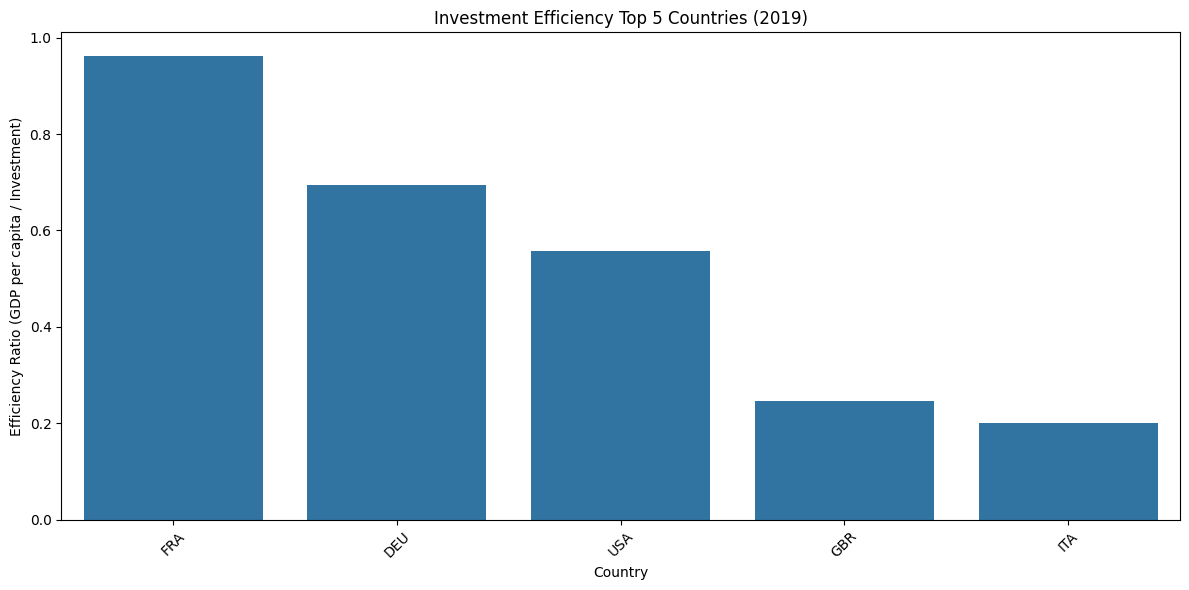


投资效率最高的前5个国家:
FRA:
  效率比率: 0.96
  人均GDP: 4.57
  教育投资: 4.75
DEU:
  效率比率: 0.69
  人均GDP: 4.55
  教育投资: 6.55
USA:
  效率比率: 0.56
  人均GDP: 3.37
  教育投资: 6.06
GBR:
  效率比率: 0.25
  人均GDP: 1.18
  教育投资: 4.78
ITA:
  效率比率: 0.20
  人均GDP: 1.21
  教育投资: 6.01


In [5]:
try:
    # 从数据库加载数据
    print("正在从数据库加载数据...")
    education_data_raw, gdp_data_raw = load_data_from_mongodb()
    
    # 打印原始数据信息
    print("\n教育数据信息:")
    print(education_data_raw.info())
    print("\nGDP数据信息:")
    print(gdp_data_raw.info())
    
    # 处理数据
    print("\n处理数据...")
    education_data_cleaned, merged_data = process_data(education_data_raw, gdp_data_raw)
    
    # 分析投资效率并生成图表
    print("\n分析投资效率...")
    print("-" * 40)
    plot_investment_efficiency(merged_data)
    
except Exception as e:
    print(f"错误: {str(e)}")
    import traceback
    print(traceback.format_exc())